##### *Copyright 2021 Google LLC*
*Licensed under the Apache License, Version 2.0 (the "License")*

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Retrain SSDLite Mobiledet object detector for the Coral Edge TPU (TF1)

This tutorial shows you how to perform transfer-learning with a pre-trained SSDLite MobileDet model so it can detect cats and dogs. We'll use TensorFlow 1.15 for training, and then use quantization-aware training and the Edge TPU Compiler to make the model compatible with the [Coral Edge TPU](https://coral.ai/products/).

Here's an example of the training results:

<img src="https://storage.googleapis.com/site_and_emails_static_assets/Images/detection-cats-and-dogs.jpg" />

**Beware:** This Colab takes about 3 hours to finish and that's only because we dialed-down a couple training parameters so it doesn't take even longer (which would cause your Colab instance to time-out and stop your training) or run out of memory. Although the results are still good, you'll get even better results (a more accurate model) if you [connect this notebook to a local runtime](https://research.google.com/colaboratory/local-runtimes.html), or upgrade to [Colab Pro](https://colab.research.google.com/signup) (which provides faster GPUs, longer run-times, and more memory), and then increase the number of training steps and the batch size.

<a href="https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_ssdlite_mobiledet_qat_tf1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"></a>
&nbsp;&nbsp;&nbsp;&nbsp;
<a href="https://github.com/google-coral/tutorials/blob/master/retrain_ssdlite_mobiledet_qat_tf1.ipynb" target="_parent"><img src="https://img.shields.io/static/v1?logo=GitHub&label=&color=333333&style=flat&message=View%20on%20GitHub" alt="View in GitHub"></a>


To start running all the code in this tutorial, select **Runtime > Run all** in the Colab toolbar.

## Install the code dependencies

In [2]:
! pip install --upgrade pip

Make sure you're using TensorFlow 1.15:

In [3]:
try:
  # This %tensorflow_version magic only works in Colab.
  %tensorflow_version 1.x
except Exception:
  pass
# For your non-Colab code, be sure you have tensorflow==1.15
import tensorflow as tf
assert tf.__version__.startswith('1')

2024-05-08 21:45:34.904487: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 21:45:34.931062: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AssertionError: 

In [ ]:
tf.__version__

Then we need to build the [TF1 Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1.md):

In [5]:
%cd /home/ajmalrasi/models/research/

/home/ajmalrasi/models/research


In [6]:
! ls

README.md	    delf			    object_detection.egg-info
adversarial_text    efficient-hrl		    pcl_rl
attention_ocr	    frozen_inference_graph.pb	    pipeline.config
audioset	    lfads			    rebar
autoaugment	    lstm_object_detection	    saved_model
build		    marco			    seq_flow_lite
checkpoint	    model.ckpt.data-00000-of-00001  setup.py
cognitive_planning  model.ckpt.index		    slim
cvt_text	    model.ckpt.meta		    vid2depth
deep_speech	    nst_blogpost
deeplab		    object_detection


In [7]:
! python object_detection/builders/model_builder_test.py

2024-05-06 09:43:08.069736: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
Using TensorFlow backend.


In [8]:
! export TF_ALLOW_IOLIBS=1

## Prepare the training dataset

Now let's get the training dataset. We're using is the [Oxford-IIIT Pets Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), which includes 37 different classes of dog and cat breeds. But for this tutorial, we'll use just 2 classes for training: Abyssinian cats and American Bulldogs.

In [9]:
%cd /home/ajmalrasi/hiba

/home/ajmalrasi/hiba


In [10]:
# Download the dataset files
%mkdir dataset
%cd dataset
! wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
! wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
! tar zxf images.tar.gz
! tar zxf annotations.tar.gz

mkdir: cannot create directory ‘dataset’: File exists
/home/ajmalrasi/hiba/dataset
--2024-05-06 00:30:39--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-05-06 00:30:40--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2024-05-06 00:30:41--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.6

In [11]:
# Only picking Abyssinian Cat and the American Bulldog
# If you wish to train the model on all classes, simply skip this entire cell
! cp /home/ajmalrasi/hiba/dataset/annotations/list.txt /home/ajmalrasi/hiba/dataset/annotations/list_petsdataset.txt
! cp /home/ajmalrasi/hiba/dataset/annotations/trainval.txt /home/ajmalrasi/hiba/dataset/annotations/trainval_petsdataset.txt
! cp /home/ajmalrasi/hiba/dataset/annotations/test.txt /home/ajmalrasi/hiba/dataset/annotations/test_petsdataset.txt
! grep "Abyssinian" /home/ajmalrasi/hiba/dataset/annotations/list_petsdataset.txt >  /home/ajmalrasi/hiba/dataset/annotations/list.txt
! grep "american_bulldog" /home/ajmalrasi/hiba/dataset/annotations/list_petsdataset.txt >> /home/ajmalrasi/hiba/dataset/annotations/list.txt
! grep "Abyssinian" /home/ajmalrasi/hiba/dataset/annotations/trainval_petsdataset.txt > /home/ajmalrasi/hiba/dataset/annotations/trainval.txt
! grep "american_bulldog" /home/ajmalrasi/hiba/dataset/annotations/trainval_petsdataset.txt >> /home/ajmalrasi/hiba/dataset/annotations/trainval.txt
! grep "Abyssinian" /home/ajmalrasi/hiba/dataset/annotations/test_petsdataset.txt > /home/ajmalrasi/hiba/dataset/annotations/test.txt
! grep "american_bulldog" /home/ajmalrasi/hiba/dataset/annotations/test_petsdataset.txt >> /home/ajmalrasi/hiba/dataset/annotations/test.txt

Now we convert the images to the [TFRecord file format](https://www.tensorflow.org/tutorials/load_data/tfrecord) we need for training:

In [12]:
%cd /home/ajmalrasi/models/research

/home/ajmalrasi/models/research


In [13]:
! cp object_detection/data/pet_label_map.pbtxt /home/ajmalrasi/hiba/dataset
! python3 object_detection/dataset_tools/create_pet_tf_record.py \
    --label_map_path="/home/ajmalrasi/hiba/dataset/pet_label_map.pbtxt" \
    --data_dir="/home/ajmalrasi/hiba/dataset" \
    --output_dir="/home/ajmalrasi/hiba/dataset"

2024-05-06 00:31:59.031165: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
I0506 00:31:59.457820 126103782725440 create_pet_tf_record.py:273] Reading from Pet dataset.
I0506 00:31:59.458152 126103782725440 create_pet_tf_record.py:287] 140 training and 60 validation examples.
I0506 00:31:59.479384 126103782725440 create_pet_tf_record.py:241] On image 0 of 140
/home/ajmalrasi/models/research/object_detection/utils/dataset_util.py:83: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:
I0506 00:31:59.562118 126103782725440 create_pet_tf_record.py:241] On image 100 of 140
W0506 00:31:59.563062 126103782725440 create_pet_tf_record.py:246] Could not find /home/ajmalrasi/hiba/dataset/annotations/xmls/Abyssinian_104.xml, ignoring example.
I0506 00:31:59.606655 126103782725440 create_pet_tf_record.py:241] On image 0 of 60


Also, create a labels file for our classes:

In [19]:
OUTPUT_DIR = '/home/ajmalrasi/hiba/output_ssdlite_mobiledet_dog_vs_cat'

In [15]:
! mkdir $OUTPUT_DIR
! echo "0 Abyssinian" >> "$OUTPUT_DIR/labels.txt"
! echo "1 american_bulldog" >> "$OUTPUT_DIR/labels.txt"

mkdir: cannot create directory ‘/home/ajmalrasi/hiba/output_ssdlite_mobiledet_dog_vs_cat’: File exists


## Prepare the model

First, let's download the pre-trained MobileDet model that's optimized for the Edge TPU:

In [16]:
!mkdir /home/ajmalrasi/hiba/pretrained_model
%cd /home/ajmalrasi/hiba/pretrained_model
! wget http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz
! tar xvf ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz

mkdir: cannot create directory ‘/home/ajmalrasi/hiba/pretrained_model’: File exists
/home/ajmalrasi/hiba/pretrained_model
--2024-05-06 00:32:00--  http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.193.123, 142.250.71.59, 142.250.195.123, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.193.123|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156413934 (149M) [application/x-tar]
Saving to: ‘ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz.4’

ssdlite_mobiledet_e 100%[===================>] 149.17M  17.8MB/s    in 10s     

2024-05-06 00:32:11 (14.9 MB/s) - ‘ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz.4’ saved [156413934/156413934]

ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/
ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/
ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/

Then we define a few variables for our training parameters:

In [11]:
# Ideally, we'd use more steps, but much larger will reach the system timeout for a free Colab environment
# If you have Colab Pro or you're running offline, try 25000
NUM_STEPS = 25000

# Ideally, batch size would be larger, but smaller is necessary to avoid OOM Killer on free Colab environments
# If you have Colab Pro or you're running offline, try 64
BATCH_SIZE = 24

# For this tutorial, we're training just two classes
# If you train with the whole cats/dogs dataset, it's 37 classes
NUM_CLASSES = 2

Next, we grab the [object detection config file](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/configuring_jobs.md) corresponding to the pre-trained model we're using, and then make some adjustments to match our training pipeline, such as the training dataset, the quantization settings, and other training parameters.

**Tip:** When training your own detection model, you should also consider adjusting the [anchor box parameters](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/configuring_jobs.md#anchor-box-parameters), which can improve the model accuracy and training speed. To generate new anchor box parameters for this dog/cat dataset, check out the Colab to [Generate SSD anchor box aspect ratios using k-means
clustering](https://colab.sandbox.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/generate_ssd_anchor_box_aspect_ratios_using_k_means_clustering.ipynb). Then use the `.config` file output by that notebook in the following section (update `config_path`).


In [12]:
import tensorflow as tf
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2
import os

pipeline = pipeline_pb2.TrainEvalPipelineConfig()
config_path = '/home/ajmalrasi/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config'
with tf.gfile.GFile(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline)

pipeline.train_input_reader.tf_record_input_reader.input_path[:] = ['/home/ajmalrasi/hiba/dataset/pet_faces_train.record-?????-of-00010']
pipeline.train_input_reader.label_map_path = '/home/ajmalrasi/hiba/dataset/pet_label_map.pbtxt'
pipeline.eval_input_reader[0].tf_record_input_reader.input_path[:] = ['/home/ajmalrasi/hiba/dataset/pet_faces_val.record-?????-of-00010']
pipeline.eval_input_reader[0].label_map_path = '/home/ajmalrasi/hiba/dataset/pet_label_map.pbtxt'
pipeline.train_config.fine_tune_checkpoint = '/home/ajmalrasi/hiba/pretrained_model/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/model.ckpt'
pipeline.train_config.batch_size = BATCH_SIZE
pipeline.train_config.num_steps = NUM_STEPS
pipeline.model.ssd.num_classes = NUM_CLASSES
# Enable ssdlite, this should already be enabled in the config we downloaded, but this is just to make sure.
pipeline.model.ssd.box_predictor.convolutional_box_predictor.kernel_size = 3
pipeline.model.ssd.box_predictor.convolutional_box_predictor.use_depthwise = True
pipeline.model.ssd.feature_extractor.use_depthwise = True
# Quantization Aware Training
pipeline.graph_rewriter.quantization.delay = 0
pipeline.graph_rewriter.quantization.weight_bits = 8
pipeline.graph_rewriter.quantization.activation_bits = 8

config_text = text_format.MessageToString(pipeline)
with tf.gfile.Open(config_path, "wb") as f:
    f.write(config_text)


You can now see our pipeline changes in the config file (such as `num_classes: 2`):

In [9]:
! cat /home/ajmalrasi/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config

model {
  ssd {
    num_classes: 2
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobiledet_edgetpu"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 4e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.03
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.97
          center: true
          scale: true
          epsilon: 0.001
          train: true
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: false
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        un

## Launch TensorBoard

TensorBoard is optional but provides very helpful visualizations of your training progress and accuracy evaluations.

Because TensorBoard runs as a webserver on your local machine—and we're actually running this on a Colab virtual environment—we'll use a tool called [ngrok](https://ngrok.com/) to make this server accessible with a public URL:

## Train the model

Here's the part that takes about 3 hours to finish (we included a training stopwatch).

In [4]:
from datetime import datetime
start = datetime.now()

In [5]:
%cd /home/ajmalrasi/models/research/
! python3 object_detection/model_main.py \
    --logtostderr=true \
    --model_dir=/home/ajmalrasi/hiba/train \
    --pipeline_config_path=/home/ajmalrasi/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config \
    --alsologtostderr \
    --tensorboard_logdir=/home/ajmalrasi/hiba/train/exp1/

/home/ajmalrasi/models/research
2024-05-06 00:46:29.378607: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
[05/06 00:46:30] tensorflow WARNING: TensorFlow will not use sklearn by default. This improves performance in some cases. To enable sklearn export the environment variable  TF_ALLOW_IOLIBS=1.
[05/06 00:46:30] tensorflow WARNING: TensorFlow will not use Dask by default. This improves performance in some cases. To enable Dask export the environment variable  TF_ALLOW_IOLIBS=1.
[05/06 00:46:30] tensorflow WARNING: TensorFlow will not use Pandas by default. This improves performance in some cases. To enable Pandas export the environment variable  TF_ALLOW_IOLIBS=1.
Using TensorFlow backend.
W0506 00:46:30.333173 129472909203264 model_lib.py:838] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: None
I0506 00:46:30.333265 129472909203264 config_util.py:552] Maybe 

In [19]:
end = datetime.now()
duration = end - start
seconds_in_hour = 60 * 60
hours, seconds = divmod(duration.seconds, seconds_in_hour)
minutes = int(seconds / 60)
print('TRAINING TIME:', str(hours) + ':' + str(minutes if minutes > 10 else '%02d' % minutes))

TRAINING TIME: 7:29


## Export the full model


This gives us the inference
graph, associated checkpoint files, a frozen inference graph, and a
SavedModel:

In [20]:
! python3 /home/ajmalrasi/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/home/ajmalrasi/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config \
    --output_directory=/home/ajmalrasi/hiba/inference_graph/ \
    --trained_checkpoint_prefix=/home/ajmalrasi/hiba/train/model.ckpt-$NUM_STEPS

2024-05-06 08:16:08.197832: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
Using TensorFlow backend.
I0506 08:16:09.705255 135052948047680 ssd_meta_arch.py:584] feature_map_spatial_dims: [(20, 20), (10, 10), (5, 5), (3, 3), (2, 2), (1, 1)]
INFO:tensorflow:depth of additional conv before box predictor: 0
I0506 08:16:09.852947 135052948047680 convolutional_box_predictor.py:154] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0506 08:16:09.880983 135052948047680 convolutional_box_predictor.py:154] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0506 08:16:09.907561 135052948047680 convolutional_box_predictor.py:154] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0506 08:16:09.935419 135052948047680 convolutional_box_predic

### Evaluate the full model

In [8]:
# Let's download some test data from flickr.
! mkdir /home/ajmalrasi/hiba/test
! cd /home/ajmalrasi/hiba/test
! wget https://live.staticflickr.com/7921/46683787864_86c9501c24_c_d.jpg -O /home/ajmalrasi/hiba/test/image1.jpg
! wget https://live.staticflickr.com/4/8451898_8bedb2ae53_c_d.jpg -O /home/ajmalrasi/hiba/test/image2.jpg
! wget https://live.staticflickr.com/2654/3997966238_f454845087_c_d.jpg -O /home/ajmalrasi/hiba/test/image3.jpg
! wget https://live.staticflickr.com/2818/34032378096_5309537c9f_c_d.jpg -O  /home/ajmalrasi/hiba/test/image4.jpg
! wget https://live.staticflickr.com/8682/28214087384_4c7711584d_c_d.jpg -O  /home/ajmalrasi/hiba/test/image5.jpg

--2024-05-06 08:09:05--  https://live.staticflickr.com/7921/46683787864_86c9501c24_c_d.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 18.67.155.82, 2600:9000:2241:9400:0:5a51:64c9:c681, 2600:9000:2241:f200:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|18.67.155.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘/home/ajmalrasi/hiba/test/image1.jpg’

/home/ajmalrasi/hib     [  <=>               ]  74.40K   360KB/s    in 0.2s    

2024-05-06 08:09:06 (360 KB/s) - ‘/home/ajmalrasi/hiba/test/image1.jpg’ saved [76189]

--2024-05-06 08:09:06--  https://live.staticflickr.com/4/8451898_8bedb2ae53_c_d.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 18.67.155.82, 2600:9000:2241:9400:0:5a51:64c9:c681, 2600:9000:2241:f200:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|18.67.155.82|:443... connected.
HTTP request sent, awaiting response

Evaluating: /home/ajmalrasi/hiba/test/image1.jpg



2024-05-06 08:17:35.068106: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcuda.so.1
2024-05-06 08:17:35.252762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-06 08:17:35.257558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3070 Ti Laptop GPU major: 8 minor: 6 memoryClockRate(GHz): 1.41
pciBusID: 0000:01:00.0
2024-05-06 08:17:35.257574: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
2024-05-06 08:17:35.273641: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2024-05-06 08:17:35.274745: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic 

Evaluating: /home/ajmalrasi/hiba/test/image2.jpg


2024-05-06 08:17:38.245270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-06 08:17:38.247007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3070 Ti Laptop GPU major: 8 minor: 6 memoryClockRate(GHz): 1.41
pciBusID: 0000:01:00.0
2024-05-06 08:17:38.247038: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
2024-05-06 08:17:38.247064: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2024-05-06 08:17:38.247070: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcufft.so.11
2024-05-06 08:17:38.247075: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynami

Evaluating: /home/ajmalrasi/hiba/test/image3.jpg


2024-05-06 08:17:39.429634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-06 08:17:39.431087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3070 Ti Laptop GPU major: 8 minor: 6 memoryClockRate(GHz): 1.41
pciBusID: 0000:01:00.0
2024-05-06 08:17:39.431109: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
2024-05-06 08:17:39.431129: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2024-05-06 08:17:39.431135: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcufft.so.11
2024-05-06 08:17:39.431140: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynami

Evaluating: /home/ajmalrasi/hiba/test/image4.jpg


2024-05-06 08:17:40.063242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-06 08:17:40.064751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3070 Ti Laptop GPU major: 8 minor: 6 memoryClockRate(GHz): 1.41
pciBusID: 0000:01:00.0
2024-05-06 08:17:40.064779: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
2024-05-06 08:17:40.064803: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2024-05-06 08:17:40.064810: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcufft.so.11
2024-05-06 08:17:40.064817: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynami

Evaluating: /home/ajmalrasi/hiba/test/image5.jpg


2024-05-06 08:17:40.734816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-06 08:17:40.736417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3070 Ti Laptop GPU major: 8 minor: 6 memoryClockRate(GHz): 1.41
pciBusID: 0000:01:00.0
2024-05-06 08:17:40.736447: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
2024-05-06 08:17:40.736471: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2024-05-06 08:17:40.736477: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcufft.so.11
2024-05-06 08:17:40.736482: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynami

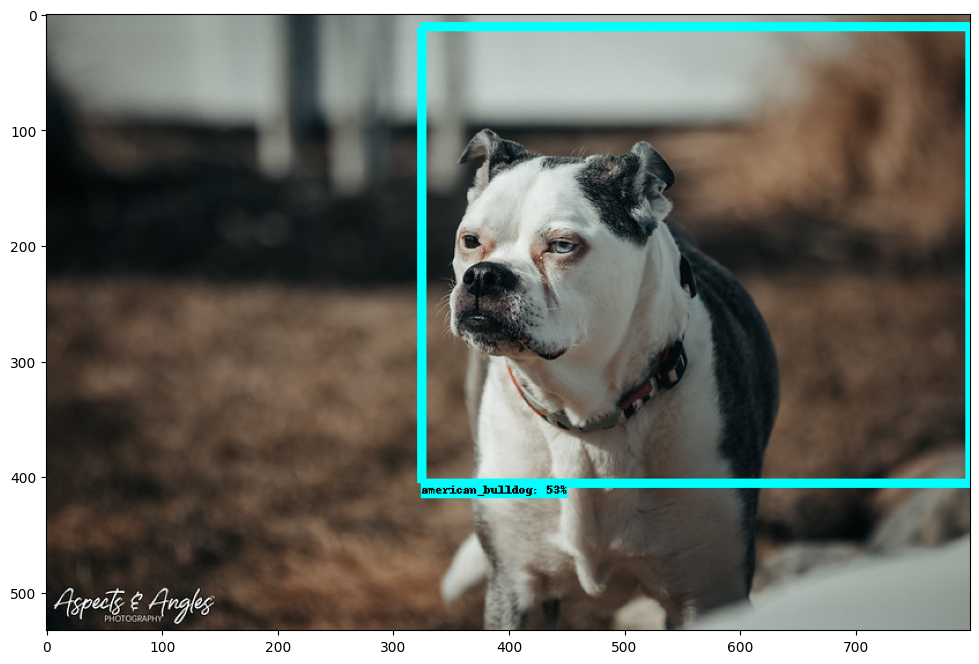

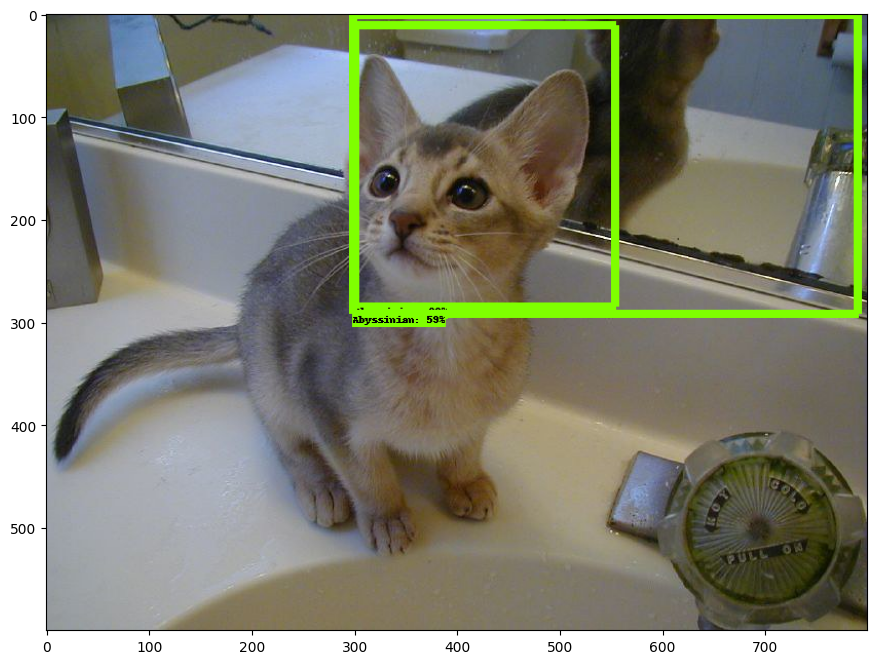

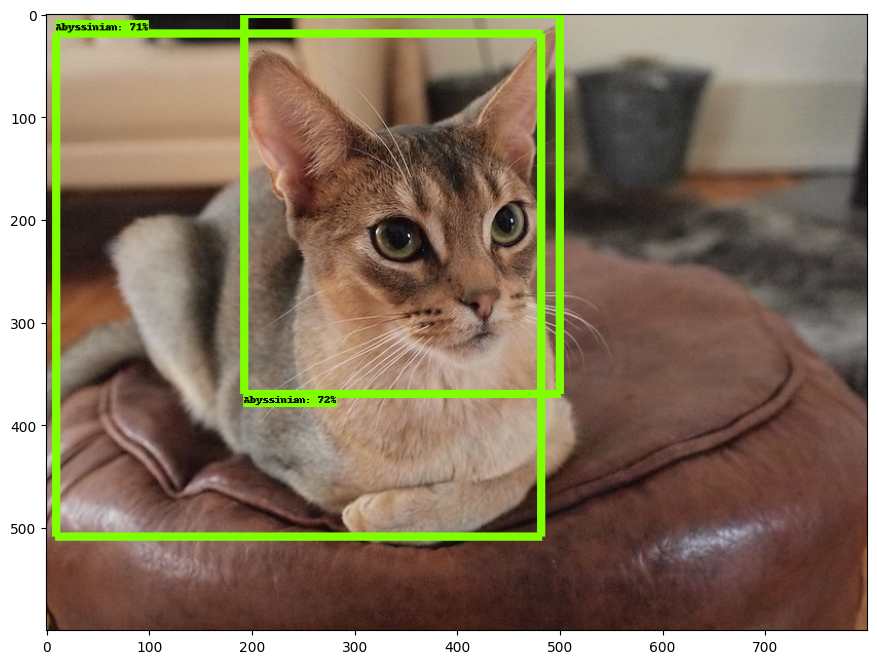

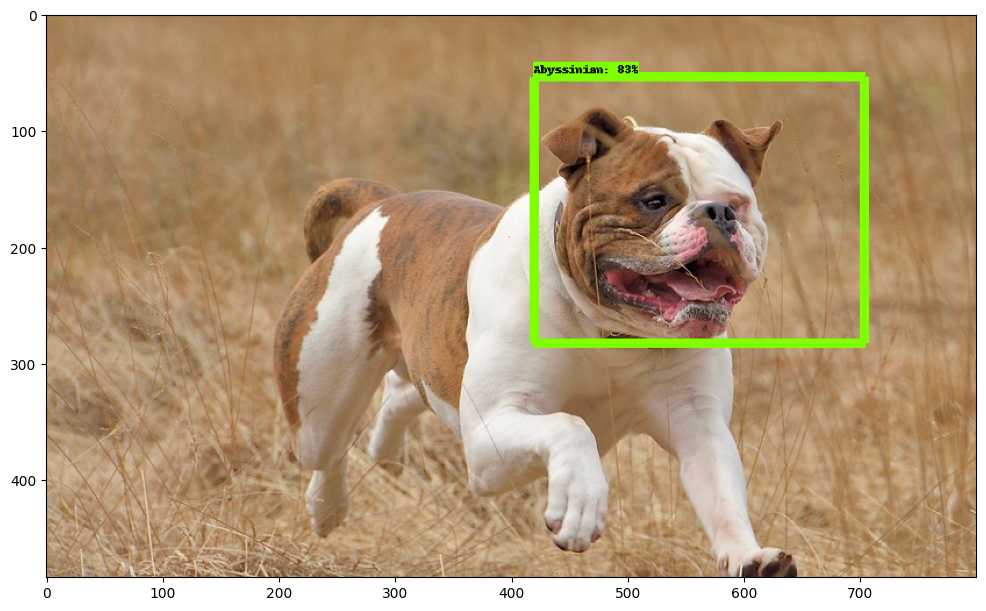

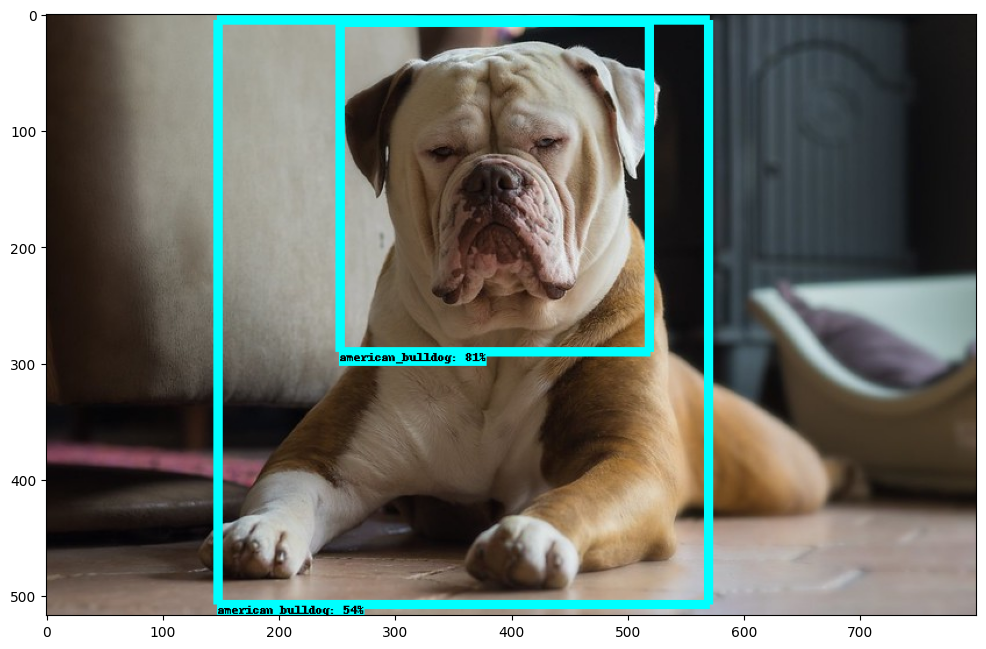

In [23]:
# Do a Quick Evaluation on the inference graph model.
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

# Initialize tf.Graph()
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile('/home/ajmalrasi/hiba/inference_graph/frozen_inference_graph.pb', 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

# Loads labels
label_map = label_map_util.load_labelmap('/home/ajmalrasi/hiba/dataset/pet_label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=2, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Run Inference and populates results in a dict.
def run_inference(graph, image):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = [output.name for op in ops for output in op.outputs]
      tensor_dict = {}
      tensor_keys = ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']
      for key in tensor_keys:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)

      # Actual inference.
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
      output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
  return output_dict

test_image_path = [os.path.join('/home/ajmalrasi/hiba/test', 'image{}.jpg'.format(i)) for i in range(1, 6)]
for image_path in test_image_path:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  img_width, img_height = image.size
  image_np = np.array(image.getdata()).reshape((img_height, img_width, 3)).astype(np.uint8)
  # Run inference.
  output_dict = run_inference(detection_graph, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=(12, 8))
  plt.imshow(image_np)

## Export to TF Lite

In [13]:
# Export this model to tflite_graph format
%cd /home/ajmalrasi/models/research

/home/ajmalrasi/models/research


In [39]:
! python3 object_detection/export_tflite_ssd_graph.py \
  --pipeline_config_path=/home/ajmalrasi/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4.config \
  --trained_checkpoint_prefix=/home/ajmalrasi/hiba/train/model.ckpt-$NUM_STEPS \
  --output_directory=$OUTPUT_DIR \
  --add_postprocessing_op=true

[Errno 2] No such file or directory: '/home/ajmalrasi/hiba/models/research'
/home/ajmalrasi/models/research
2024-05-06 08:24:45.738165: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
Using TensorFlow backend.
I0506 08:24:47.207421 138940861585216 ssd_meta_arch.py:584] feature_map_spatial_dims: [(20, 20), (10, 10), (5, 5), (3, 3), (2, 2), (1, 1)]
INFO:tensorflow:depth of additional conv before box predictor: 0
I0506 08:24:47.352004 138940861585216 convolutional_box_predictor.py:154] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0506 08:24:47.376416 138940861585216 convolutional_box_predictor.py:154] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0506 08:24:47.400923 138940861585216 convolutional_box_predictor.py:154] depth of additional conv before box predictor: 0
INFO:tensorflow:dep

In [12]:
! ls output_ssdlite_mobiledet_dog_vs_cat

labels.txt  tflite_graph.pb  tflite_graph.pbtxt


In [1]:
def resize_with_padding_pillow(img, desired_size=640):
    """Resizes an image with padding using Pillow (PIL).

    Args:
        img (PIL.Image): The input image.
        desired_size (int): The desired output size (assumes square output).

    Returns:
        PIL.Image: The resized and padded image.
    """

    old_size = img.size  # (width, height)
    ratio = float(desired_size) / max(old_size)  # Calculate scaling ratio
    new_size = tuple([int(x * ratio) for x in old_size])  # Compute new dimensions

    # Resize the image with high-quality resampling 
    img = img.resize(new_size, Image.Resampling.LANCZOS)

    # Calculate padding needed
    new_img = Image.new("RGB", (desired_size, desired_size), (0, 0, 0))  # Black background
    pad_w = (desired_size - new_size[0]) // 2
    pad_h = (desired_size - new_size[1]) // 2

    # Paste the resized image onto the new image with padding
    new_img.paste(img, (pad_w, pad_h))

    return new_img

In [28]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://ultralytics.com/images/bus.jpg")
image = Image.open(BytesIO(response.content))


In [3]:
image = Image.open("models/pklot.jpg")

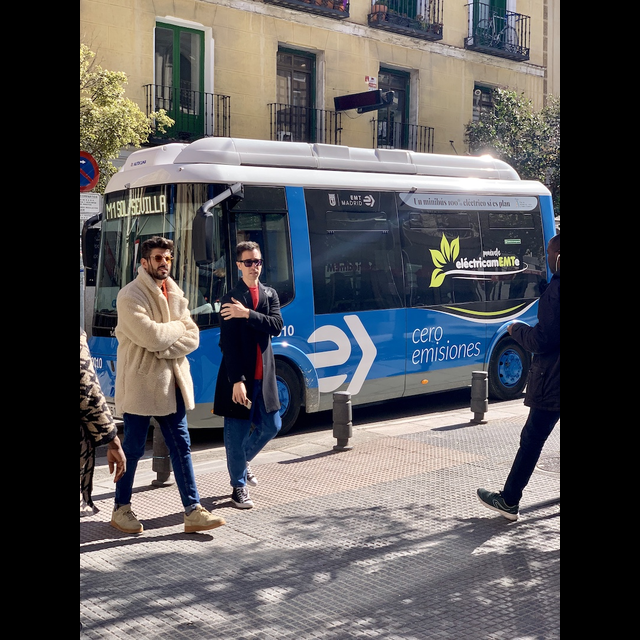

In [29]:
image = resize_with_padding_pillow(image, desired_size=640)
image

In [5]:
import tensorflow as tf
import numpy as np
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="models/yolov8n_float32.tflite")
interpreter.allocate_tensors()

# Get input and output details (you'll need to adjust for your model)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

2024-05-08 22:25:07.008625: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 22:25:07.035003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [6]:
input_details

[{'name': 'inputs_0',
  'index': 0,
  'shape': array([  1, 640, 640,   3], dtype=int32),
  'shape_signature': array([  1, 640, 640,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [7]:
output_details

[{'name': 'Identity',
  'index': 409,
  'shape': array([   1,   84, 8400], dtype=int32),
  'shape_signature': array([   1,   84, 8400], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [30]:
input_img_tensor = np.expand_dims(np.array(image).astype(np.float32), axis = 0)
input_img_tensor.shape

(1, 640, 640, 3)

In [31]:
# input_data = (input_img_tensor - 127.5) / 127.5
input_data = input_img_tensor / 255.0

In [32]:
input_data

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)

In [33]:
interpreter.set_tensor(0, input_data)

In [34]:
interpreter.invoke()

In [35]:
output_tensor = interpreter.get_tensor(409)

In [36]:
idx = output_tensor[:,4:] [output_tensor[:,4:] > 0.5]

In [37]:
dims = np.where(output_tensor[:,4:] > 0.5)

In [39]:
np.array(dims).T

array([[   0,    0, 8187],
       [   0,    0, 8204],
       [   0,    0, 8207],
       [   0,    0, 8208],
       [   0,    0, 8216],
       [   0,    0, 8224],
       [   0,    0, 8225],
       [   0,    0, 8227],
       [   0,    0, 8228],
       [   0,    0, 8235],
       [   0,    0, 8236],
       [   0,    0, 8244],
       [   0,    0, 8245],
       [   0,    0, 8247],
       [   0,    0, 8248],
       [   0,    0, 8255],
       [   0,    0, 8256],
       [   0,    0, 8264],
       [   0,    0, 8265],
       [   0,    0, 8267],
       [   0,    0, 8268],
       [   0,    0, 8275],
       [   0,    0, 8276],
       [   0,    0, 8284],
       [   0,    0, 8285],
       [   0,    0, 8295],
       [   0,    0, 8296],
       [   0,    5, 8149],
       [   0,    5, 8150],
       [   0,    5, 8151],
       [   0,    5, 8169],
       [   0,    5, 8170],
       [   0,    5, 8171],
       [   0,    5, 8189],
       [   0,    5, 8190],
       [   0,    5, 8191]])

In [27]:
output_tensor[0,:,1623][:4] * 640

array([194.34903 , 164.14055 ,  36.697483,  18.890724], dtype=float32)

In [4]:
graph_def = tf.compat.v1.GraphDef()
with open('models/saved_model.pb', 'rb') as f:
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')


print([node.name for node in graph_def.node if node.op == 'Placeholder'])  # Print input names
# Print output names using a suitable way to identify them in your graph

DecodeError: Error parsing message with type 'tensorflow.GraphDef'

In [ ]:
converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model()

In [96]:
import tensorflow as tf
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file = 'output_ssdlite_mobiledet_dog_vs_cat/tflite_graph.pb', 
    input_arrays = ['normalized_input_image_tensor'],
    output_arrays = ['TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3'],
    input_shapes = {"normalized_input_image_tensor" : [1, 320, 320, 3]}
)

2024-05-06 18:22:14.690987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-06 18:22:14.696057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-06 18:22:14.699681: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [97]:
converter.quantized_input_stats = {
    'normalized_input_image_tensor': (128, 128),
}

In [102]:
converter.allow_custom_ops=True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_type = tf.int8
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

In [103]:
tflite_model = converter.convert()
with tf.io.gfile.GFile('output_ssdlite_mobiledet_dog_vs_cat/ssdlite_mobiledet_dog_vs_cat.tflite', 'wb') as f:
  f.write(tflite_model)

W0000 00:00:1715000102.558881  380368 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1715000102.558898  380368 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-05-06 18:25:02.878403: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:3007] The following operation(s) need TFLite custom op implementation(s):
Custom ops: TFLite_Detection_PostProcess
Details:
	tf.TFLite_Detection_PostProcess(tensor<1x2034x4xf32>, tensor<1x2034x3xf32>, tensor<2034x4xf32>) -> (tensor<*xf32>, tensor<*xf32>, tensor<*xf32>, tensor<*xf32>) : {_output_quantized = true, _output_types = [f32, f32, f32, f32], _support_output_type_float_in_quantized_op = true, detections_per_class = 100 : i64, device = "", h_scale = 5.000000e+00 : f32, max_classes_per_detection = 1 : i64, max_detections = 10 : i64, nms_iou_threshold = 6.000000e-01 : f32, nms_score_threshold = 9.99999993E-9 : f32, num_classes = 2 : i64, use_regular_nms = false, w_scale = 5.000000e+00 : f32, x_scale = 1.00

In [63]:
# # Convert to a tflite file (for CPU)
# ! tflite_convert \
#   --output_file="$OUTPUT_DIR/ssdlite_mobiledet_dog_vs_cat.tflite" \
#   --graph_def_file="$OUTPUT_DIR/tflite_graph.pb" \
#   --inference_type=QUANTIZED_UINT8 \
#   --input_arrays="normalized_input_image_tensor" \
#   --output_arrays="TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3" \
#   --mean_values=128 \
#   --std_dev_values=128 \
#   --input_shapes=1,320,320,3 \
#   --allow_custom_ops

### Evaluate the TF Lite model

In [41]:
import os
import re
import numpy as np
from PIL import Image
from PIL import ImageDraw
%matplotlib inline

# Creates tflite interpreter
interpreter = tf.lite.Interpreter(OUTPUT_DIR + '/ssdlite_mobiledet_dog_vs_cat.tflite')
interpreter.allocate_tensors()
interpreter.invoke() # warmup
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
width = input_details[0]['shape'][2]
height = input_details[0]['shape'][1]

def read_label_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
  ret = {}
  for row_number, content in enumerate(lines):
    pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
    if len(pair) == 2 and pair[0].strip().isdigit():
      ret[int(pair[0])] = pair[1].strip()
    else:
      ret[row_number] = content.strip()
  return ret

def run_inference(interpreter, image):
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()
  boxes = interpreter.get_tensor(output_details[0]['index'])[0]
  classes = interpreter.get_tensor(output_details[1]['index'])[0]
  scores = interpreter.get_tensor(output_details[2]['index'])[0]
  # num_detections = interpreter.get_tensor(output_details[3]['index'])[0]
  return boxes, classes, scores

test_image_paths = [os.path.join('/content/test', 'image{}.jpg'.format(i)) for i in range(1, 6)]
for image_path in test_image_paths:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  image_width, image_height = image.size
  draw = ImageDraw.Draw(image)
  resized_image = image.resize((width, height))
  np_image = np.asarray(resized_image)
  input_tensor = np.expand_dims(np_image, axis=0)
  # Run inference
  boxes, classes, scores = run_inference(interpreter, input_tensor)
  # Draw results on image
  colors = {0:(128, 255, 102), 1:(102, 255, 255)}
  labels = read_label_file(OUTPUT_DIR + '/labels.txt')
  for i in range(len(boxes)):
    if scores[i] > .7:
      ymin = int(max(1, (boxes[i][0] * image_height)))
      xmin = int(max(1, (boxes[i][1] * image_width)))
      ymax = int(min(image_height, (boxes[i][2] * image_height)))
      xmax = int(min(image_width, (boxes[i][3] * image_width)))
      draw.rectangle((xmin, ymin, xmax, ymax), width=7, outline=colors[int(classes[i])])
      draw.rectangle((xmin, ymin, xmax, ymin-10), fill=colors[int(classes[i])])
      text = labels[int(classes[i])] + ' ' + str(scores[i]*100) + '%'
      draw.text((xmin+2, ymin-10), text, fill=(0,0,0), width=2)
  display(image)

## Compile it for the Edge TPU

Install the [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/):

Compile the model for the Edge TPU:

In [104]:
! edgetpu_compiler -s output_ssdlite_mobiledet_dog_vs_cat/ssdlite_mobiledet_dog_vs_cat.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 755 ms.

Input model: output_ssdlite_mobiledet_dog_vs_cat/ssdlite_mobiledet_dog_vs_cat.tflite
Input size: 3.30MiB
Output model: ssdlite_mobiledet_dog_vs_cat_edgetpu.tflite
Output size: 4.30MiB
On-chip memory used for caching model parameters: 4.11MiB
On-chip memory remaining for caching model parameters: 3.40MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 138
Operation log: ssdlite_mobiledet_dog_vs_cat_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 135
Number of operations that will r

## Package and download all files

In [ ]:
! cp -r /content/train/model.ckpt-$NUM_STEPS* $OUTPUT_DIR
! cp -r /content/inference_graph/* $OUTPUT_DIR

%cd /content/
! tar cvf output_ssdlite_mobiledet_dog_vs_cat.tar.gz output_ssdlite_mobiledet_dog_vs_cat

In [ ]:
from google.colab import files
files.download('/content/output_ssdlite_mobiledet_dog_vs_cat.tar.gz')

## Run it on the Edge TPU




You can now run the model on your [Coral device](https://www.coral.ai/products) with acceleration on the Edge TPU.

First, find some new photos to try. Remember that you've trained this model to recognize just two classes: Abyssinian cats and
American Bulldogs. So here are a couple images that should provide results (provided by the
[Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html)):

```
wget https://c4.staticflickr.com/8/7580/15865399370_ffa5b49d20_z.jpg -O dog.jpg && \
wget https://c6.staticflickr.com/9/8534/8652503705_687d957a29_z.jpg -O cat.jpg
```

Then, try running an inference using [this example code for the PyCoral API](https://github.com/google-coral/pycoral/blob/master/examples/detect_image.py). Just clone that repo and run the script using the model files you downloaded above (also be sure you have [installed the PyCoral API](https://coral.ai/software/#pycoral-api)):

```
git clone https://github.com/google-coral/pycoral

cd pycoral/examples/

python3 detect_image.py \
  --model ssdlite_mobiledet_dog_vs_cat_edgetpu.tflite \
  --labels labels.txt \
  --input dog.jpg \
  --output dog_result.jpg
```

Check out more examples for running inference at [coral.ai/examples](https://coral.ai/examples/#code-examples/).